In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column, vstack, join

import numpy as np 

import matplotlib.pyplot as plt

## Halo Mass Function

- Goals: learn how to estimate halo mass functions (HMFs) under different cosmology models.
    - Focus on the high-mass end (galaxy clusters).
    - Try different fitting models and different halo mass definitions.
    - As default, we will use the `Tinker08` fitting model with virial halo mass definition (`Mvir`)
    
- Motivation: cluster abundance is very sensitive to the high-mass end of HMF, hence also sensitive to cosmology.
    - Different cluster finder calibrate their method under different cosmology models. And that can affect their results.
    - e.g. See [Murata et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..107M/abstract), especially Fig.7 & 9.
    
    ```We also show that the scatter values for the Planck model increase toward lower richness values, whereas those for the WMAP model are consistent with constant values as a function of richness. This result highlights the importance of the scatter in the mass-richness relation for cluster cosmology.```

- Different calibration papers:
    1. [Murata et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..107M/abstract): 
        - HSC CAMIRA; `DSigma` + abundance
        - Use $M_{200\rm m}$; 200 times of present day mean mass density
        - `Planck15` cosmology: $\Omega_{{\rm b0}h^2}=0.02225$, $\Omega_{{\rm c0}h^2}=0.1198$, $\Omega_{\Lambda}=0.6844$, $\sigma_{8}=0.831$, $n_{s}=0.9645$.
        - `WMAP9` cosmology: $\Omega_{{\rm b0}h^2}=0.02254$, $\Omega_{{\rm c0}h^2}=0.1142$, $\Omega_{\Lambda}=0.721$, $\sigma_{8}=0.82$, $n_{s}=0.97$.
    2. [Murata et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...854..120M/abstract): 
        - SDSS redMaPPer; `DSigma` + abundance.
        - Use $M_{200\rm m}$; 200 times of present day mean mass density
        - `Planck15` cosmology: $\Omega_{{\rm b0}h^2}=0.02225$, $\Omega_{{\rm c0}h^2}=0.1198$, $\Omega_{\Lambda}=0.6844$, $\sigma_{8}=0.831$, $n_{s}=0.9645$, and $\ln(10^{10}A_s)=3.094$.
    3. [Baxter et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463..205B/abstract):
        - SDSS redMaPPer NorthGC; angular clustering.
        - Use $M_{200\rm m}$; 200 times of present day mean mass density
        - `Planck15` cosmology: $\Omega_{\rm m}=0.309$, $\Omega_{\rm b}=0.0486$, $h_{0}=0.677$, $\tau=0.066$, $n_s=0.9667$, $A_s=2.14\times 10^{-9}$.
        - Including a scatter parameter, but did not estimate Posterior.
    4. [Simet et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466.3103S/abstract):
        - SDSS redMaPPer; weak lensing.
        - Assuming flat $\Lambda \rm CDM$ model with $\Omega_{\rm m}=0.3$, $\sigma_8=0.8$, and $h=1.0$.
    5. [Melchior et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.469.4899M/abstract):
        - DES SV data; redMaPPer; 
        - Spanning ranges in the richness parameter $5 < \lambda < 180$ and redshift $0.2 < z < 0.8$.
        - Use $M_{200\rm m}$; 200 times of present day mean mass density
        - Assuming flat $\Lambda \rm CDM$ model with $\Omega_{\rm m}=0.3$, $h=0.7$.

### `Colossus`

* [`Colossus`](http://www.benediktdiemer.com/code/colossus/) by Benedikt Diemer is a python toolkit for calculations pertaining to cosmology, the large-scale structure of the universe, and the properties of dark matter halos.
    - More details can be found in this [paper](https://ui.adsabs.harvard.edu/abs/2018ApJS..239...35D/abstract)
    - With a lot of available cosmology models: `planck18`, `planck15`, `WMAP9`, `WMAP7`, 'illustris`, 'multidark-planck`, `bolshoi`.
    - With a lof of HMF: `sheth99`, `tinker08`, `watson13`, `despali16`. (See Fig2).
    - See this [Juypyter tutorial here](https://bdiemer.bitbucket.io/colossus/_static/tutorial_lss_mass_function.html)
   
* We try three different HMF models:
    - [Tinker et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008ApJ...688..709T/abstract)
    - [Watson et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013MNRAS.433.1230W/abstract)
    - [Despali et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.2486D/abstract)

In [3]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

In [6]:
z_list = [0.2, 0.3, 0.4, 0.5]
mvir_arr = 10. ** np.arange(12.0, 15.5, 0.05)

In [47]:
cosmology.setCosmology('planck18');
print(cosmology.setCosmology('planck18'))

hmf_t08_planck = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='tinker08', q_out='dndlnM') for z in z_list]

hmf_w13_planck = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='watson13', q_out='dndlnM') for z in z_list]

hmf_d16_planck = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='despali16', q_out='dndlnM') for z in z_list]

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [48]:
cosmology.setCosmology('WMAP9');
print(cosmology.setCosmology('WMAP9'))

hmf_t08_wmap = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='tinker08', q_out='dndlnM') for z in z_list]

hmf_w13_wmap = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='watson13', q_out='dndlnM') for z in z_list]

hmf_d16_wmap = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='despali16', q_out='dndlnM') for z in z_list]

Cosmology "WMAP9" 
    flat = True, Om0 = 0.2865, Ode0 = 0.7134, Ob0 = 0.0463, H0 = 69.32, sigma8 = 0.8200, ns = 0.9608
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [49]:
cosmology.setCosmology('illustris');
print(cosmology.setCosmology('illustris'))

hmf_t08_illustris = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='tinker08', q_out='dndlnM') for z in z_list]

hmf_w13_illustris = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='watson13', q_out='dndlnM') for z in z_list]

hmf_d16_illustris = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='despali16', q_out='dndlnM') for z in z_list]

Cosmology "illustris" 
    flat = True, Om0 = 0.2726, Ode0 = 0.7274, Ob0 = 0.0456, H0 = 70.40, sigma8 = 0.8090, ns = 0.9630
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


* Cosmology based on the [DES Y1 cluster cosmology results](https://arxiv.org/pdf/2002.11124.pdf)

In [42]:
# Modify the `Om0` and `sigma8` parameters based on `planck18`
des_y1 = {'flat': True, 'H0': 67.66, 'Om0': 0.179, 'Ob0': 0.049, 'sigma8': 0.85, 'ns': 0.9665}
cosmology.setCosmology('des_y1', des_y1)

hmf_t08_des = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='tinker08', q_out='dndlnM') for z in z_list]

hmf_w13_des = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='watson13', q_out='dndlnM') for z in z_list]

hmf_d16_des = [
    mass_function.massFunction(mvir_arr, z, mdef='vir', model='despali16', q_out='dndlnM') for z in z_list]

#### Redshift evolution

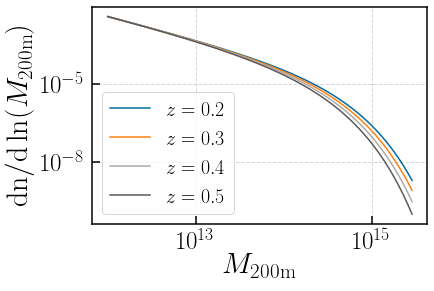

In [19]:
plt.loglog()
plt.xlabel(r'$M_{200\rm m}$', fontsize=30);
plt.ylabel(r'${\rm dn}/{\rm d}\ln(M_{200\rm m})$', fontsize=30);
plt.plot(mvir_arr, hmf_t08_planck[0], label=r'$z=0.2$')
plt.plot(mvir_arr, hmf_t08_planck[1], label=r'$z=0.3$')
plt.plot(mvir_arr, hmf_t08_planck[2], label=r'$z=0.4$')
plt.plot(mvir_arr, hmf_t08_planck[3], label=r'$z=0.5$')
plt.legend(fontsize=20, loc='best');

#### Different HMF models

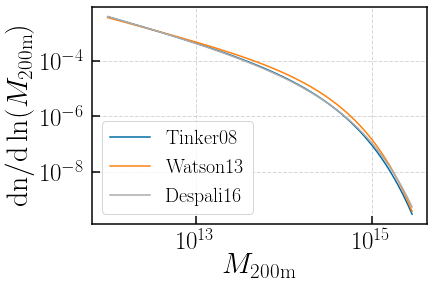

In [20]:
plt.loglog()
plt.xlabel(r'$M_{200\rm m}$', fontsize=30);
plt.ylabel(r'${\rm dn}/{\rm d}\ln(M_{200\rm m})$', fontsize=30);
plt.plot(mvir_arr, hmf_t08_planck[2], label=r'$\rm Tinker08$')
plt.plot(mvir_arr, hmf_w13_planck[2], label=r'$\rm Watson13$')
plt.plot(mvir_arr, hmf_d16_planck[2], label=r'$\rm Despali16$')
plt.legend(fontsize=20, loc='best');

#### Different Cosmology

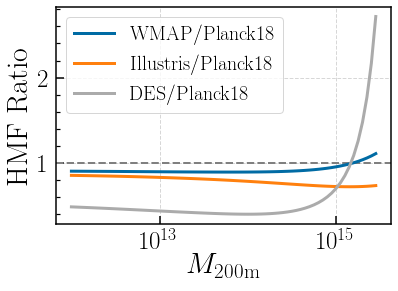

In [46]:
plt.xscale('log')
plt.xlabel(r'$M_{200\rm m}$', fontsize=30);
plt.ylabel(r'$\rm HMF\ Ratio$', fontsize=30);
plt.axhline(1.0, linewidth=2.0, linestyle='--', c='grey')
plt.plot(mvir_arr, hmf_t08_wmap[2] / hmf_t08_planck[2], label=r'$\rm WMAP/Planck18$', linewidth=3.0)
plt.plot(mvir_arr, hmf_t08_illustris[2] / hmf_t08_planck[2], label=r'$\rm Illustris/Planck18$', linewidth=3.0)
plt.plot(mvir_arr, hmf_t08_des[2] / hmf_t08_planck[2], label=r'$\rm DES/Planck18$', linewidth=3)
plt.legend(fontsize=20, loc='best');